# Ритейл — Анализ программы лояльности

ОПИСАНИЕ ДАННЫХ:\
Датасет содержит данные о покупках в магазине строительных материалов «Строили, строили и наконец построили». \
Все покупатели могут получить доступ в магазин с использованием персональных карт. \
За 200 рублей в месяц они могут стать участниками программы лояльности. \
В программу включены скидки, специальные предложения, подарки.

ЗАДАЧИ ПРОЕКТА:\
Провести исследовательский анализ данных;\
Провести анализ программы лояльности;\
Сформулировать и проверить статистические гипотезы.\
Оценить возможности развития программы лояльности.

## Загрузка данных.
Загрузка и первичный осмотр, получение общей информации о наборах данных.

В нашем распоряжении два датасета:\
retail_dataset.csv - журнал продаж\
product_codes.csv - стоимость товара

In [379]:
#загрузим нужные библиотеки
import pandas as pd
import numpy as np
from numpy import mean
import warnings
import math as mth
import datetime as dt
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objects as go 
warnings.simplefilter("ignore")

In [380]:
#загрузим данные
try:
   product, retail = (
    pd.read_csv("C:\\Users\\kirio\\OneDrive\\Рабочий стол\\ЯПрактикум\\14_Выпускной Проект\\product_codes.csv", sep=','), #стоимость товара
    pd.read_csv('C:\\Users\\kirio\\OneDrive\\Рабочий стол\\ЯПрактикум\\14_Выпускной Проект\\retail_dataset.csv', sep=',') #журнал продаж
)
except:
   product, retail = (
    pd.read_csv('https://code.s3.yandex.net/datasets/product_codes.csv', sep=','), #стоимость товара
    pd.read_csv('https://code.s3.yandex.net/datasets/product_codes.csv', sep=',') #журнал продаж
)

### Изучение датасетов

In [381]:
# функция для вывода информации о датасетах
def gen_info(data):
    data.info()
    display(data.head())

retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;

In [382]:
#журнал продаж
gen_info(retail)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара;

In [383]:
#стоимость товара
gen_info(product)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


В датасете retail_dataset журнала продаж 105335 строк, 7 столбцов. Три типа данных: object, float64 и int64. В столбце 'CustomerID' есть пропущенные значения.\
В датасете product_codes стоимости товара 9969 строк, два столбца. Два типа данных: object и float64. Пропусков нет.

Для выявления ошибок в данных посмотрим на категориальные и числовые значения.\
Для  числовых используем describe(), показывающий распределение величин,\
а для  категориальных  метод value_counts(), показывающий значения и их количество.

In [384]:
# распределение велечин для retail
for column in ['purchaseid', 'item_ID', 'CustomerID', 'ShopID', 'loyalty_program']:
    print(column, retail[column].value_counts(), '\n', sep='\n')
print('Quantity', retail['Quantity'].describe(), sep='\n');

purchaseid
537434     675
538071     652
538349     620
537638     601
537237     597
          ... 
C538745      1
C538114      1
539052       1
536374       1
542225       1
Name: purchaseid, Length: 4894, dtype: int64


item_ID
85123A      565
22423       499
22469       414
22720       377
85099B      372
           ... 
16169N        1
35644         1
DCGS0057      1
84723         1
m             1
Name: item_ID, Length: 3159, dtype: int64


CustomerID
18427.0    796
23520.0    757
20285.0    751
20990.0    718
20590.0    549
          ... 
23956.0      1
18184.0      1
21827.0      1
20288.0      1
18182.0      1
Name: CustomerID, Length: 1749, dtype: int64


ShopID
Shop 0     97393
Shop 4      1741
Shop 1      1540
Shop 6      1032
Shop 8       560
Shop 3       492
Shop 7       312
Shop 10      299
Shop 12      278
Shop 18      256
Shop 2       253
Shop 5       179
Shop 11      169
Shop 14      154
Shop 19       74
Shop 9        61
Shop 15       60
Shop 16       59
Shop 25      

In [385]:
# распределение велечин для product
print('\nproductID', product['productID'].value_counts(), sep='\n')
print('\nprice_per_one', product['price_per_one'].describe(), sep='\n');


productID
DOT       174
M          59
S          29
POST       15
D          13
         ... 
21228       1
22596       1
90058B      1
90081A      1
85018D      1
Name: productID, Length: 3159, dtype: int64

price_per_one
count     9969.000000
mean        19.503697
std        330.880754
min          0.000000
25%          1.250000
50%          2.550000
75%          5.510000
max      16888.020000
Name: price_per_one, dtype: float64


### Выводы по датасетам:
Всего 4894 чеков purchaseid, самое большое количество товаров в чеке '537434' - 675.\
Уникальных товаров item_ID и productID всего 3159, это число в датасетах одинаково.\
Всего в сети 31 магазин, столбец ShopID, наибольшее количество покупок в Shop 0, возможно это онлайн магазин.\
Уникальных покупателей CustomerID - 1749, наибольшее количество товаров у одного покупателя - 796. \
Большинство покупок совершается без программы лояльности (ПЛ), по ПЛ куплено примерно 23% товаров.\
По распределению количества товаров Quantity среднее значение 7, есть отрицательные значения, возможно это возвраты.\
Максимальные и минимальные значения: 74214 и -74216, возможно это выбросы.\
Нулевое количество, возможно, при получении данных были ошибки.\
Цены товара price_per_one, распределение  выглядит нормально:\
среднее значение 19.5, медианное 2.55, минимальная цена - 0, возможно это товары по акции, которые идут в подарок или ошибки в данных.\
Максимальная цена - 16888, это либо дорогой товар либо выброс.

## Предобработка данных.
Переименование и добавление столбцов. Удаление дубликатов. Исследованее пропущенных значений.  Преобразование типов данных.   

### Переименование столбцов.

In [386]:
#переименуем названия столбцов
retail = retail.rename(
   columns={
       'purchaseid': 'purchase_id',\
       'item_ID': 'item_id',\
       'Quantity': 'quantity',\
       'purchasedate': 'purchase_date',\
       'CustomerID': 'customer_id',\
       'ShopID': 'shop_id'\
   }
)
product = product.rename(columns={'productID': 'item_id', 'price_per_one':'price'}).reset_index(drop=True)

### Удаление дубликатов.

In [387]:
#количество явных дубликатов в датафреймах
print('Число дубликатов retail:', retail.duplicated().sum())
print('Число дубликатов product:', product.duplicated().sum())

Число дубликатов retail: 1033
Число дубликатов product: 0


In [388]:
#удалим из датафрейма строки с дубликатами, оставив только первые вхождения: будем считать, что верные идентификаторы встречаются первыми
retail = retail.drop_duplicates(keep='first').reset_index(drop=True)
#количество строк после удаления дубликатов
retail.shape

(104302, 7)

### Преобразование типов данных.

In [389]:
#преобразуем типы данных в столбцах loyalty_program в целое и purchase_date к дате 
retail['loyalty_program'] = retail['loyalty_program'].astype('int')
retail['purchase_date'] = pd.to_datetime(retail['purchase_date'])

### Исследование пропущенных значений.

In [390]:
#количество пропусков в столбце customer_id
retail['customer_id'].isna().sum()

36148

In [391]:
# % пропусков в столбце customer_id
pd.DataFrame(round(retail.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
purchase_id,0.000000
item_id,0.000000
quantity,0.000000
purchase_date,0.000000
customer_id,35.000000
shop_id,0.000000
loyalty_program,0.000000


In [392]:
#срез по событиям незарегистрированных пользователей не участвующих в программе лояльности 
retail.query('loyalty_program == 0')['customer_id'].isna().sum()

36148

Треть (35%) пользователей совершили покупки без регистрации (количество: 36148) и все они не участвуют в программе лояльности.\
В нашем исследовании гипотезы основаны на следующих метриках: средний чек, среднее количество покупок и выручка которую  клиент в среднем принёс компании.\
Все они рассчитываются на каждого клиента, в случае замены на "заглушки", отсутствующие значения могут быть интерпретированы как действия одного клиента с множеством покупок.\
Удалить или "заглушить" 35% датасета неприемлемо - исказятся данные клиентов не участвующих в программе лояльности.\
Присвоим идентификаторы customer_id, заменив пропуски на purchase_id, они уникальны как покупка.

In [393]:
#заменим пропуски на уникальные purchase_id
retail['customer_id'] = retail['customer_id'].fillna(retail['purchase_id'])
#выведем количество уникальных пользователей по группе лояльности
retail.groupby('loyalty_program').agg({'customer_id':'nunique'})

,customer_id
loyalty_program,
0,1910
1,587


### Добавим новый столбец.

In [394]:
#добавим новые столбцы в retail с днями недели
retail['weekday'] = retail['purchase_date'].dt.weekday
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,5
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1,2
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1,2
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1,3
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1,0


### Вывод:
На данном этапе мы привели к значения столбцов к нужному формату, проиндексировали датафремы и изменили названия столбцов для удобства работы.\
Также мы заполнили пропуски в столбце customer_id - присвоили идентификатор чека. Удалили явные дубликаты.\
Данные прошли предобработку и соответствуют необходимому уровню качества для дальнейшего интеллектуального анализа и проверке гипотез.

## Исследовательский анализ данных (EDA).
Выявление аномалий и выбросов. Группировка по лояльности и значимым признакам. Расчет долей, среднего чека, кумулятивной средней выручки лояльных покупателей относительно остальных. Поиск корреляций и особенностей. Анализ категорий по дням недели и неделям, за весь период. Визуализация распределения данных и результатов исследований с помощью графиков и диаграмм. Промежуточные выводы.

### Выявление аномалий и выбросов.

In [395]:
#посмотрим на рапределение цены price в таблице product
product['price'].describe()


count     9969.000000
mean        19.503697
std        330.880754
min          0.000000
25%          1.250000
50%          2.550000
75%          5.510000
max      16888.020000
Name: price, dtype: float64

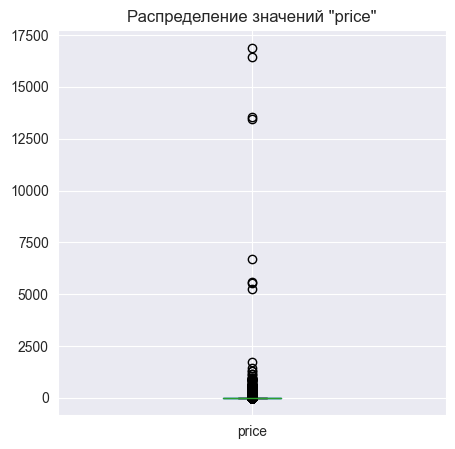

In [396]:
#построим боксплот
product.boxplot(column='price', figsize=(5,5))
plt.title('Распределение значений "price"')
plt.show()

Диаграмма "ящик с усами" показывает, что почти все значения распологаются вблизи 0.

In [397]:
#посмотрим на товар с самой высокой ценой
max_price = product['price'].max()
product.query('price == @max_price')

,item_id,price
6133,AMAZONFEE,16888.02


In [398]:
#выведем этот товар
product.query('item_id == "AMAZONFEE"')

,item_id,price
3891,AMAZONFEE,1.00
3931,AMAZONFEE,13541.33
4089,AMAZONFEE,13474.79
4094,AMAZONFEE,5519.25
4095,AMAZONFEE,6706.71
6133,AMAZONFEE,16888.02
6134,AMAZONFEE,16453.71
9732,AMAZONFEE,5575.28
9733,AMAZONFEE,5258.77


У AMAZONFEE 9 разных цен. Возможно, это разные товары с Амазона, но id у них одинаковый.\
Сгруппируем товары и посмотрим количество значений цен товара.

In [399]:
#сгруппируем и отсортируем по убыванию
product.groupby('item_id').agg({'price': 'nunique'}).sort_values(by='price', ascending=False)

,price
item_id,
DOT,174
M,59
S,29
POST,15
D,13
...,...
85018C,1
85018D,1
85019B,1


In [400]:
#количество нулевых цен
len(product.query('price == [0]'))

382

У многих товаров несколько ценовых значений. Есть 382 нулевых, вероятно это акционный или подарочный товар. 

Отфильтруем строки с нулевой ценой. Сгруппируем таблицу  по item_id и посчитаем среднюю цену.\
Очистим данные от выбросов, посчитав 99-й квантиль, отфильтруем по нему датасет.

In [401]:
# удаление нулевых цен
product = product.query('price != 0').pivot_table(
    index='item_id', values='price', aggfunc='mean').reset_index()

# расчет границы выбросов
upper_border = product['price'].quantile(0.99)
print('Граница выбросов:', upper_border)
print('Доля выбросов:', round(
    len(product.query('price > @upper_border'))/len(product), 2))

# фильтрация выбросов
product = product.query('price <= @upper_border')
product

Граница выбросов: 29.58974999999967
Доля выбросов: 0.01


,item_id,price
0,10002,1.380000
1,10080,0.850000
2,10120,0.210000
3,10123C,0.650000
4,10124A,0.420000
...,...,...
3092,DCGSSGIRL,3.290000
3095,POST,17.826429
3097,gift_0001_20,16.845000
3098,gift_0001_30,25.265000


Датасет product отфильтрован от нулей и выбросов, граница выбросов 29.6, теперь в нем 3070 строк.

Перейдем к обработке датасета retail. Еще раз выведем распределение значений quantity - количества товара.

In [402]:
#распредиление числовых значений
retail['quantity'].describe()

count    104302.000000
mean          7.883003
std         329.565540
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64

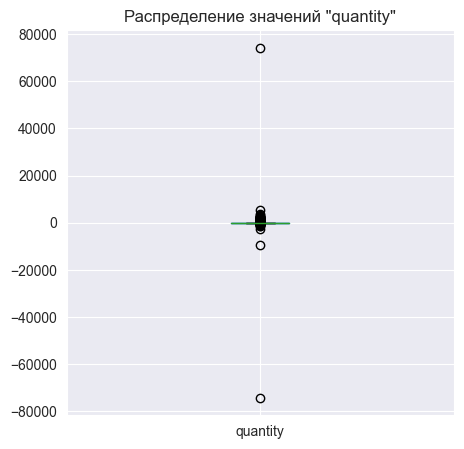

In [403]:
#построим боксплот
retail.boxplot(column='quantity', figsize=(5,5))
plt.title('Распределение значений "quantity"')
plt.show()

По диаграмме видно, что весь "ящик с усами" распологается около нуля. Нулевое количество товара возможно если это ошибка пробития в чеке, отмена покупки и товар не приобретен, или ошибка в сборе данных. Нет смысла работать со строками с нулевым количеством, стоимость у них будет тоже 0. Удалим эти значения.

In [404]:
#выведем количество 0 строк и отфильтруем датасет
print('Число строк с нулевым количеством товара:', retail.query('quantity == 0').shape[0])
retail = retail.query('quantity != 0')

Число строк с нулевым количеством товара: 32362


Удалили 32362 строки с 0 количеством товара. Это треть датасета. 

In [405]:
#посмотрим на строки с максиамальным и минимальным количесвом товаров
quantity_max = retail['quantity'].max()
quantity_min = retail['quantity'].min()
retail.query('quantity == @quantity_max or quantity == @quantity_min')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday
49166,C541433,23166,-74216,2017-01-18 10:17:00,18025.0,Shop 0,0,2
68612,541431,23166,74214,2017-01-18 10:01:00,18025.0,Shop 0,0,2


Это покупки одного покупателя '18025'. Сначала было куплено 74214 едениц товара '541431', а отрицательное значение это возврат 74216 товаров. Странно, что вернули, больше, чем купили.

Видим возвратный чек с литерой "С", выведем все подобные чеки.

In [406]:
#чеки с отрицательным количеством
retail.query('quantity < 0')

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday
64,C539944,22776,-2,2016-12-23 11:38:00,20239.0,Shop 0,0,4
109,C542910,20726,-2,2017-02-01 15:38:00,23190.0,Shop 0,1,2
112,C542426,22418,-25,2017-01-28 09:32:00,19825.0,Shop 0,0,5
253,C539726,22791,-11,2016-12-21 14:24:00,22686.0,Shop 0,1,2
344,C544034,21878,-2,2017-02-15 11:28:00,20380.0,Shop 0,0,2
...,...,...,...,...,...,...,...,...
104132,C541650,M,-2,2017-01-20 11:44:00,C541650,Shop 0,0,4
104143,C540246,79320,-2,2017-01-05 15:43:00,18760.0,Shop 0,0,3
104180,C539467,22801,-2,2016-12-19 12:46:00,20723.0,Shop 0,0,0
104217,C540847,22197,-3,2017-01-11 17:35:00,19137.0,Shop 0,0,2


Действительно, все чеки с возвратом, начинаются на букву "C", их 2 тысячи. Возвраты в данных оставим. Отфильтруем выбросы.

Рассчитаем выбросы, используем межквартильный размах (IQR). Это разница между Q3 и Q1.\
Редкие значения будут меньше Q1 - 1.5 * IQR, а выбивающиеся значения больше Q3 + 1.5 * IQR.\
Для наших значений используем коэффицент 3.

In [407]:
q1 = retail['quantity'].quantile(0.25)
q3 = retail['quantity'].quantile(0.75)
iqr = q3 - q1
# границы интервала наиболее вероятных значений
lower_border = q1 - 3 * iqr
upper_border = q3 + 3 * iqr
# вывод границ и доли выбросов
print(f'Границы выбросов: {lower_border}, {upper_border}')
print('Доля выбросов:', round(
    len(retail.query('quantity < @lower_border or quantity > @upper_border'))/len(retail), 4))

Границы выбросов: -29.0, 41.0
Доля выбросов: 0.0487


Границы выбросов quantity -29 и 41. Доля значений, которую мы удалим по этим границам, будет 4,87%.

In [408]:
# фильтрация выбросов
retail = retail.query('quantity >= @lower_border and quantity <= @upper_border')
retail

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,5
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1,2
7,541424,79321,1,2017-01-17 17:57:00,541424,Shop 0,0,1
10,537795,82494L,5,2016-12-08 13:03:00,22892.0,Shop 0,1,3
11,541696,22197,4,2017-01-20 18:08:00,541696,Shop 0,0,4
...,...,...,...,...,...,...,...,...
104296,540154,22134,3,2017-01-05 11:30:00,540154,Shop 0,0,3
104297,538566,21826,1,2016-12-13 11:21:00,538566,Shop 0,0,1
104299,538068,85048,1,2016-12-09 14:05:00,23657.0,Shop 0,1,4
104300,538207,22818,11,2016-12-10 11:33:00,18427.0,Shop 0,0,5


Обработанный от пропусков и выбросов датасет retail содержит 68434 строки. Отфильтровано много, зато теперь, данные чистые.

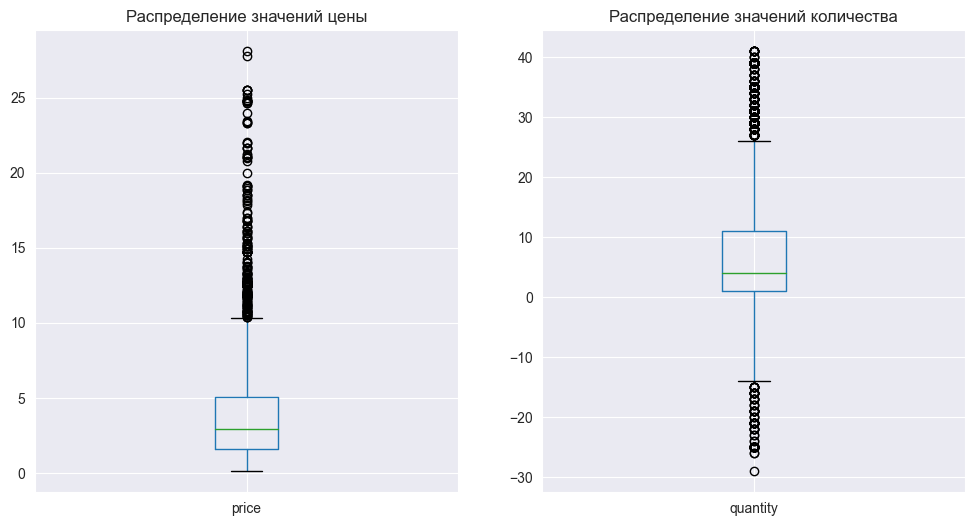

In [409]:
#Построим боксплоты для product 'price' и retail 'quantity'
fig, axes = plt.subplots(1, 2, figsize=(12,6))

product.boxplot(column='price', ax=axes[0])
axes[0].set_title('Распределение значений цены')

retail.boxplot(column='quantity',ax=axes[1])
axes[1].set_title('Распределение значений количества')

plt.show()

Без нулей и выбросов значения читаемы. Теперь можно объеденить данные в одну таблицу.

### Объединение журнала продаж и стоимости товара.

Объеденим таблицы по id товара. Итоговую цену чека, посчитаем в столбце total, помноженную на количество из столбца quantity.

In [410]:
#объединение таблиц
data = retail.merge(product, on='item_id', how='left')
# расчет стоимости
data['total'] = data['price'] * data['quantity']
#посчитаем товары без цены
data['total'].isna().sum()

208

In [411]:
# удаляем строки без total
data = data.query('not price.isna()')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68226 entries, 0 to 68433
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      68226 non-null  object        
 1   item_id          68226 non-null  object        
 2   quantity         68226 non-null  int64         
 3   purchase_date    68226 non-null  datetime64[ns]
 4   customer_id      68226 non-null  object        
 5   shop_id          68226 non-null  object        
 6   loyalty_program  68226 non-null  int32         
 7   weekday          68226 non-null  int64         
 8   price            68226 non-null  float64       
 9   total            68226 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(4)
memory usage: 5.5+ MB


In [412]:
#выведем датасет
data

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday,price,total
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,5,1.810000,19.910000
1,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1,2,1.474000,10.318000
2,541424,79321,1,2017-01-17 17:57:00,541424,Shop 0,0,1,7.715000,7.715000
3,537795,82494L,5,2016-12-08 13:03:00,22892.0,Shop 0,1,3,5.145000,25.725000
4,541696,22197,4,2017-01-20 18:08:00,541696,Shop 0,0,4,1.215000,4.860000
...,...,...,...,...,...,...,...,...,...,...
68429,540154,22134,3,2017-01-05 11:30:00,540154,Shop 0,0,3,0.632500,1.897500
68430,538566,21826,1,2016-12-13 11:21:00,538566,Shop 0,0,1,2.073333,2.073333
68431,538068,85048,1,2016-12-09 14:05:00,23657.0,Shop 0,1,4,11.368000,11.368000
68432,538207,22818,11,2016-12-10 11:33:00,18427.0,Shop 0,0,5,0.700000,7.700000


### Вывод:
Строки с нулями в количестве товаров quantity и цены price были удалены, что составило треть от данных.\
Эти же переменные были почищенны от выбросов, в таблице retail отфильтровано 4,9%, в таблице product 1%.\
Два датасета были объединены в data. В столбце total расчитана общая стоимость (цена * количество).\
Отфильтровано 208 строк, для которых цена неизвестна.\
В таблице data 68226 строк, 11 столбцов.

### Исследование по дате продаж.

In [413]:
#временной период 
data['purchase_date'].describe()

count                   68226
unique                   3921
top       2016-12-06 16:57:00
freq                      331
first     2016-12-01 08:26:00
last      2017-02-28 17:01:00
Name: purchase_date, dtype: object

Отделим данные о покупках, без возратов.\
Построим гистограмму для значения даты и дня недели по всем строкам - это будет количество товаров.\
Построим гистограмму для чеков - покупок, сгруппировав таблицу по purchase_id.\
Для визуализации используем plotly.

In [414]:
#отделим данные о покупках, без возратов
data_purchase = data.query('quantity >= 0')

In [415]:
#гистграмма для товаров по дате
fig = px.histogram(data_purchase, x="purchase_date", title = 'Распределение товаров по дате', nbins=100)
fig.update_layout(yaxis_title="Количество товаров", xaxis_title="Дата")
fig.show()

#гистграмма для покупок по дате
fig = px.histogram(data_purchase.groupby('purchase_id').agg({'purchase_date': 'max'}), 
                   x="purchase_date", title = 'Распределение покупок по дате', nbins=100)
fig.update_layout(yaxis_title="Количество покупок", xaxis_title="Дата")
fig.show()

In [416]:
#гистграмма для товаров по дню недели
fig = px.histogram(data_purchase, x="weekday", title = 'Распределение товаров по дню недели', nbins=7)
fig.update_layout(yaxis_title="Количество товаров", xaxis_title="День недели",
                  height=300,
                  width=700)
fig.show()

#гистграмма для покупок по дню недели
fig = px.histogram(data_purchase.groupby('purchase_id').agg({'weekday': 'max'}), 
                   x="weekday", title = 'Распределение покупок по дню недели', nbins=7)
fig.update_layout(yaxis_title="Количество покупок", xaxis_title="День недели",
                  height=300,
                  width=700)
fig.show()

Набор данных за период (три месяца): с 2016-12-01 по 2017-02-28. Покупок гораздо меньше, чем товаров, что видно на графиках по оси y - количеству.

По графикам видно - в первой половине декабря покупок в 2 раза больше, чем в следующие месяцы. Сезонный, высокой спрос перед праздниками.\
Отсутствуют покупки в период с 24 декабря по 3 января, во многих странах, период Рождества.\
Воскресенье - выходной день. В пятницу покупают больше, чем в остальные дни.\
По товарам есть пик во вторник, видимо активны оптовые покупатели.


### Исследование продаж по магазинам.

Рассмотрим данные о покупках data_purchase. Сгруппируем датасет по магазинам shop_id.\
Выведем топ-10 по числу чеков purchase_id, числу проданных товаров quantity и сумме выручки price.\
Построим столбчатые диаграммы.

In [417]:
# таблица по магазинам
shop = data_purchase.groupby('shop_id').agg(
    {'purchase_id': 'nunique', 'quantity': 'sum', 'total': 'sum'}
).reset_index()
shop['total'] = shop['total'].round(1)

In [418]:
#функция для получения столбчатой диаграммы
def gen_shop(column='purchase_id', title='График'):
    plt.figure(figsize=(8,4))
    #топ-10 по данному столбцу
    sns.barplot(x="shop_id", y=column, data=shop.sort_values(by=column, ascending=False).head(10))
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Магазины')
    plt.show()

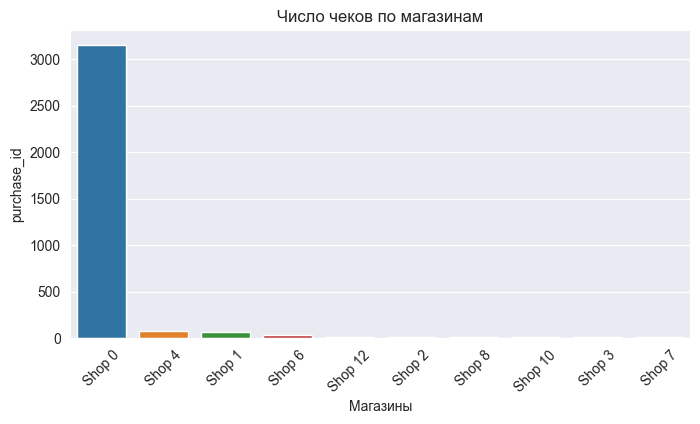

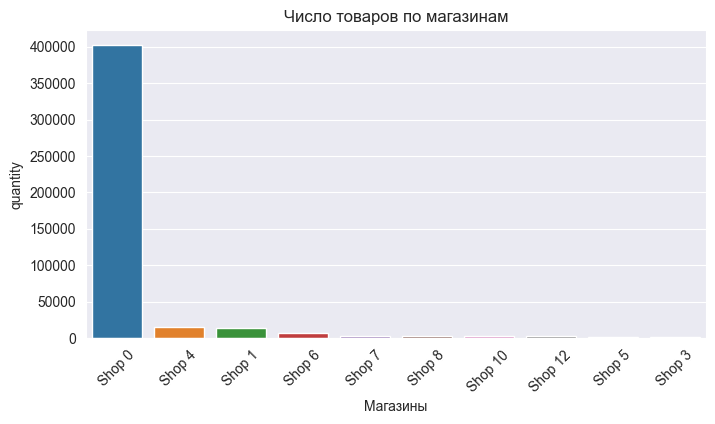

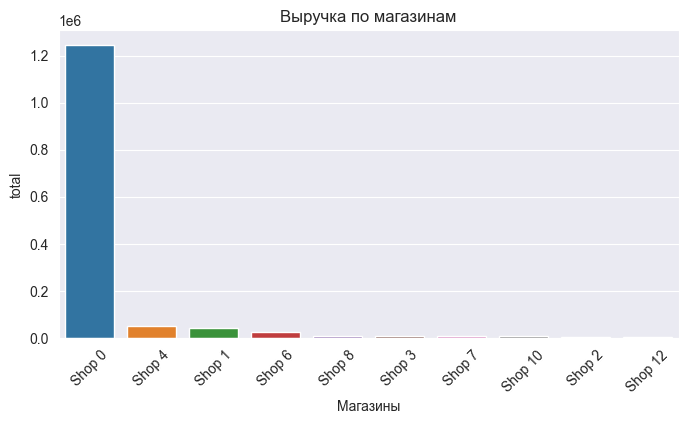

In [419]:
# вызов функции
gen_shop('purchase_id', 'Число чеков по магазинам')
gen_shop('quantity', 'Число товаров по магазинам')
gen_shop('total', 'Выручка по магазинам')

In [420]:
# вывод сводной таблицы
shop.sort_values(by=['purchase_id', 'quantity', 'total'], ascending=False).head(10)

,shop_id,purchase_id,quantity,total
0,Shop 0,3155,402382,1245142.5
24,Shop 4,79,16061,50125.2
1,Shop 1,70,14653,42047.2
26,Shop 6,36,7527,27367.2
4,Shop 12,16,2404,6215.4
12,Shop 2,15,1490,6734.3
28,Shop 8,14,3489,11467.9
2,Shop 10,12,2648,9288.7
22,Shop 3,11,2088,9857.4
27,Shop 7,10,3594,9586.0


Магазин "Shop 0" лидирует по всем парметрам продаж с большим отрывом.\
Вероятно самый большой, через него могут проходить онлайн-заказы с самовывозом и доставкой.\
В "Shop 0" количество чеков в 30 раз больше, чем в других магазинах.\
В топ-5 по количеству покупок также входят магазины № 4, 1, 6 и 12. В топ-5 по выручке № 4, 1, 6 и 8.

### Исследование продаж по покупателю

Сгруппируем данные по покупателю customer_id.\
Рассчитаем количество чеков, товаров, сумму потраченных денег.\
Напишем функцию для построения гистограмм по полученным данным.\
Возвраты учитывать не будем.

In [421]:
# сводная таблица
customer = data_purchase.groupby('customer_id').agg(
    {'purchase_id': 'nunique', 'quantity': 'sum', 'total': 'sum'})

In [422]:
# функция построения гистограмм
def gen_hist(data, column, title):
    data[column].hist(figsize=(10, 5), bins=100)
    plt.title(title)
    plt.xlabel(column)
    plt.show()

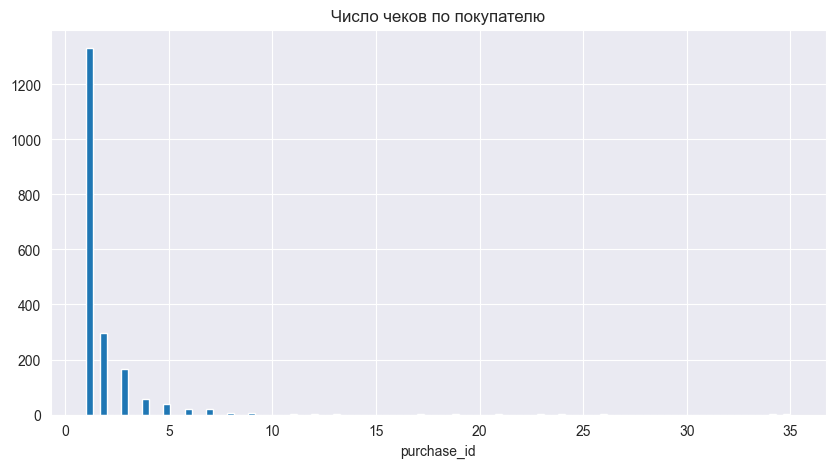

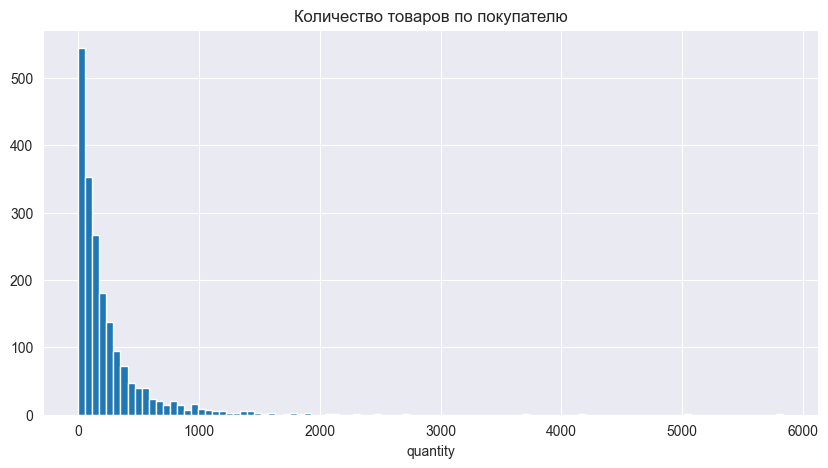

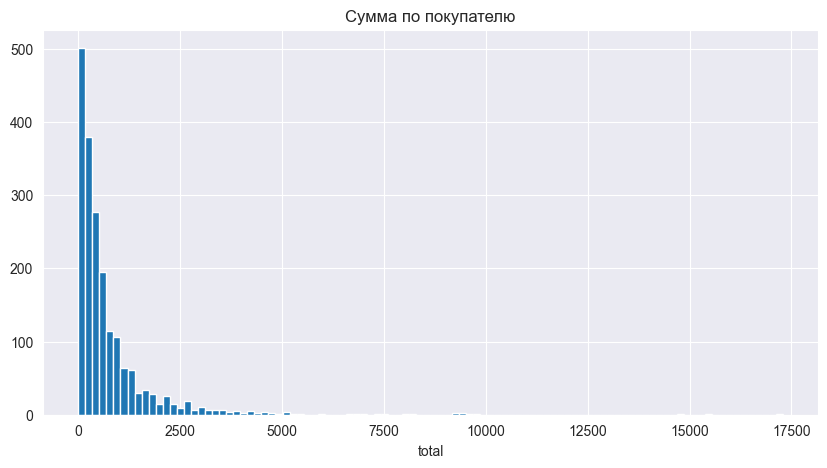

In [423]:
# вызов функции
gen_hist(customer, column='purchase_id', title='Число чеков по покупателю')
gen_hist(customer, column='quantity', title='Количество товаров по покупателю')
gen_hist(customer, column='total', title='Сумма по покупателю')

In [424]:
#числовые характеристики
customer.describe().round(1)

,purchase_id,quantity,total
count,1956.0,1956.0,1956.0
mean,1.8,240.2,748.9
std,2.1,358.7,1193.9
min,1.0,1.0,0.4
25%,1.0,52.0,169.3
50%,1.0,135.0,399.8
75%,2.0,286.0,854.9
max,35.0,5832.0,17287.4


Всего 1956 покупателей.\
Графики количества товаров и суммы чека  по покупателю распределены как случайная величина, значит данные в порядке.\
Максимальное число покупок (чеков) - 35, число товаров 5832\
Минимальная сумма чеков 0.4, максимальная 17287.4\
Средние значения:\
Число чеков 1.8\
Количество товаров 240.2\
Потраченная сумма 748.9

### Исследование продаж по чекам.

Сгруппируем данные по чекам, посчитаем:\
общее количество товаров,\
число уникальных товаров,\
сумму чека.
Сохраним значения в переменную purchase.\
Выведем числовые характеристики распределений методом describe\
Построим гистограммы с помощью функции gen_hist\
Возвраты учитывать не будем

In [425]:
# сводная таблица 
purchase = data_purchase.groupby('purchase_id').agg(
    {'quantity': 'sum', 'item_id': 'nunique', 'total': 'sum'}
).reset_index()
purchase['total'] = purchase['total'].round(1)

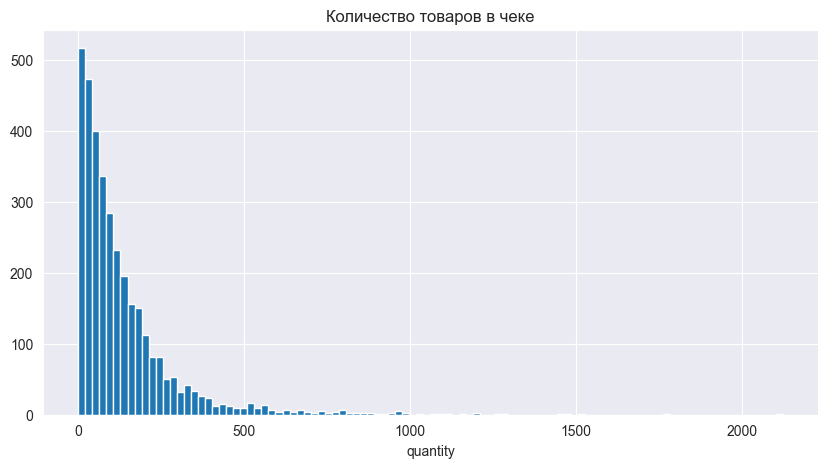

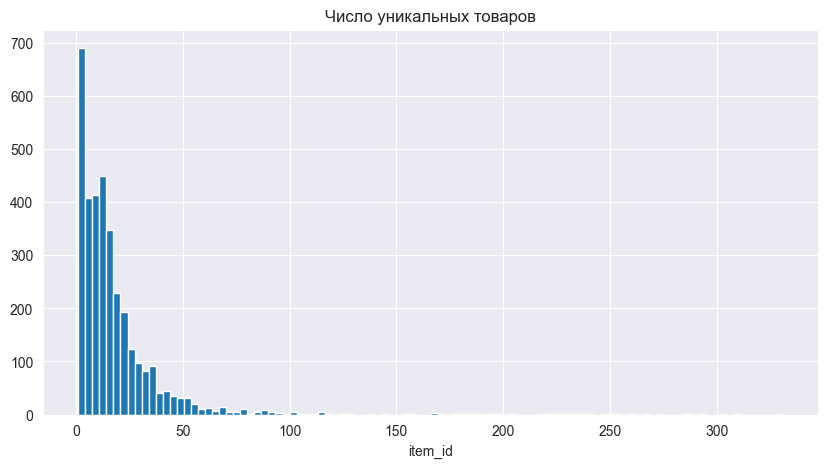

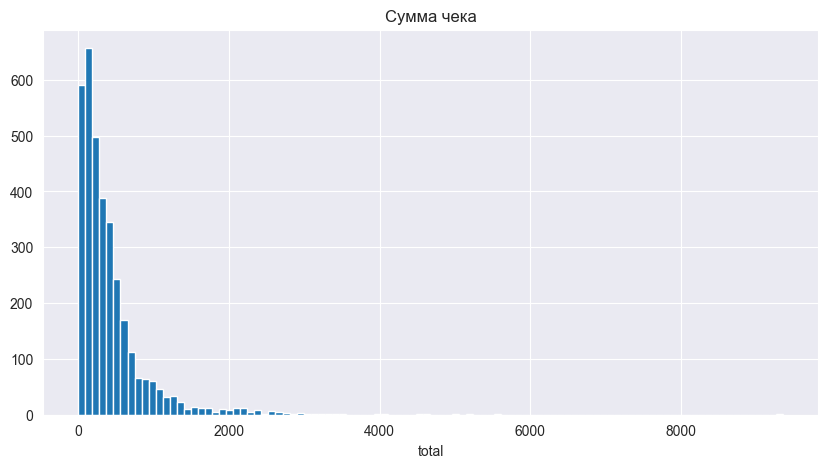

In [426]:
# вызов функции
gen_hist(purchase, column='quantity', title='Количество товаров в чеке')
gen_hist(purchase, column='item_id', title='Число уникальных товаров')
gen_hist(purchase, column='total', title='Сумма чека')

In [427]:
#числовые характеристики
purchase.describe().round(1)

,quantity,item_id,total
count,3471.0,3471.0,3471.0
mean,135.3,19.1,422.0
std,164.4,28.5,517.6
min,1.0,1.0,0.4
25%,37.0,6.0,130.7
50%,86.0,12.0,278.5
75%,171.0,22.0,513.3
max,2124.0,331.0,9351.6


In [428]:
#количество чеков
data['purchase_id'].nunique()

4250

Всего 4250 чеков, из них 3471 чеков покупок. Средний чек, составляет 422. Медианное значение - 278.5\
Все распределения на гистограммах имеют пиковые значения в начале.\
Графики количества товаров и суммы чека  распределены как случайная величина, значит данные в порядке.\
Число уникальных товаров, чаще значения меньше 5, в начале сильный пик.\
Среднее количество товаров в чеке - 135, медианное - 86. Среднее смещается из-за чеков с большим количеством товаров.\
Среднее число уникальных товаров в чеке - 19, медианное 12.


### Выводы:

На этапе исследовательского анализа данных, были исследованы зависимости и распределения параметров.

В датасете данные от 1 декабря 2016 года до 28 февраля 2017 года - 3 месяца.\
Сеть стоительных магазинов не работает по воскресеньям, были рождественские каникулы 24 декабря - 3 января.\
Перед праздниками покупок было больше.

Магазин "Shop 0" лидирует по всем параметрам продаж.\
Возможно он основной и самый большой, через него могут проходить онлайн-заказы с самовывозом и доставкой.\
Количество покупок в 30 раз больше, чем в других магазинах.\
По количеству покупок и выручке среди остальных магазинов популярнее № 4, 1, 6, 8, 12.

Всего 4250 чеков, из них 3471 чеков покупок. Средний чек, составляет 422. Медианное значение - 278.5\
Среднее количество товаров в чеке - 135, среднее число уникальных товаров в чеке - 19

Всего 1956 покупателей. Средние значения: число чеков 1.8, количество товаров 240, потраченная сумма 749.

## Анализ программы лояльности

Рассмотрим отдельно группы клиентов в программе лояльности и остальных, это признак loyalty_program, будем использовать только покупки без возвратов - data_purchase

### Сводная таблица средних значений по группам

In [451]:
#сводная таблица
lp_groupby = data_purchase.groupby('loyalty_program').agg(
    {'purchase_id': 'nunique', 'customer_id': 'nunique', 'quantity': 'mean', 'price': 'mean', 'purchase_date': 'min'})
#переименуем столбцы
lp_groupby = lp_groupby.rename(
    {'purchase_id': 'Число чеков', 'customer_id': 'Число клиентов', 'quantity': 'Среднее число товаров',
    'price': 'Средняя цена товара', 'purchase_date': 'Дата и время первого чека'}, axis=1).round(1)
#добавим столбец средней выручки  и % от всех пользователей
lp_groupby['Средняя выручка'] = lp_groupby['Среднее число товаров']*lp_groupby['Средняя цена товара']
lp_groupby['% от всех клиентов'] = (lp_groupby['Число клиентов']/(data_purchase['customer_id'].nunique())*100).round(1)
lp_groupby


,Число чеков,Число клиентов,Среднее число товаров,Средняя цена товара,Дата и время первого чека,Средняя выручка,% от всех клиентов
loyalty_program,,,,,,,
0,2410,1413,7.0,4.0,2016-12-01 08:34:00,28.00,72.2
1,1061,543,7.1,4.1,2016-12-01 08:26:00,29.11,27.8


Клиентов с программой лояльности 27.8%. Среднее число товаров - 7 и средняя цена товара - 4 у обеих выборок одинаковы.\
Пока не видно разницы в покупках клиентов по программе лояльности с остальными.

### Распределение по покупкам

Проведем анализ по покупкам, с группировкой по purchase_id. Все остальные переменные агрегируем, переименуем столбцы.

In [430]:
# сводная таблица 
df_purchase = data_purchase.groupby('purchase_id').agg(
    {'customer_id': 'max', 'item_id': 'nunique', 'quantity': 'sum', 'price': 'mean', 'total': 'sum', 
     'shop_id': 'max', 'purchase_date': 'max', 'loyalty_program': 'max'}
).reset_index()
# округлим цены
df_purchase[['price', 'total']] = df_purchase[['price', 'total']].round(1)
# переименуем столбцы
df_purchase.columns = ['Чек', 'Покупатель', 'Уник. товары', 'Все товары', 
                            'Ср. цена за товар', 'Сумма чека', 'Магазин', 'Дата', 'ПЛ']
df_purchase

,Чек,Покупатель,Уник. товары,Все товары,Ср. цена за товар,Сумма чека,Магазин,Дата,ПЛ
0,536365,23529.0,7,33,6.7,194.9,Shop 0,2016-12-01 08:26:00,1
1,536366,23529.0,2,10,2.7,27.2,Shop 0,2016-12-01 08:28:00,1
2,536367,18726.0,12,71,6.7,307.5,Shop 0,2016-12-01 08:34:00,0
3,536368,18726.0,4,11,8.2,84.5,Shop 0,2016-12-01 08:34:00,0
4,536369,18726.0,1,2,8.3,16.6,Shop 0,2016-12-01 08:35:00,0
...,...,...,...,...,...,...,...,...,...
3466,545214,22844.0,10,90,4.7,216.4,Shop 0,2017-02-28 16:39:00,1
3467,545215,545215,78,239,3.1,682.7,Shop 0,2017-02-28 16:47:00,0
3468,545216,545216,46,190,2.9,545.3,Shop 0,2017-02-28 16:50:00,0
3469,545217,545217,48,189,2.6,486.3,Shop 0,2017-02-28 16:59:00,0


Всего 3471 покупок. Построим по ним графики histplot и kdeplot.\
Посмотрим на распределения значений в зависимости от программы лояльности (ПЛ), указав hue="ПЛ".

In [431]:
#для корректного отображения графика "Покупатель" отфильтруем пользователей без регистрации(им присваивали id>500000)
df_purchase['Покупатель'] = df_purchase['Покупатель'].astype('int')
df_purchase_filter = df_purchase.query("Покупатель < 500000")

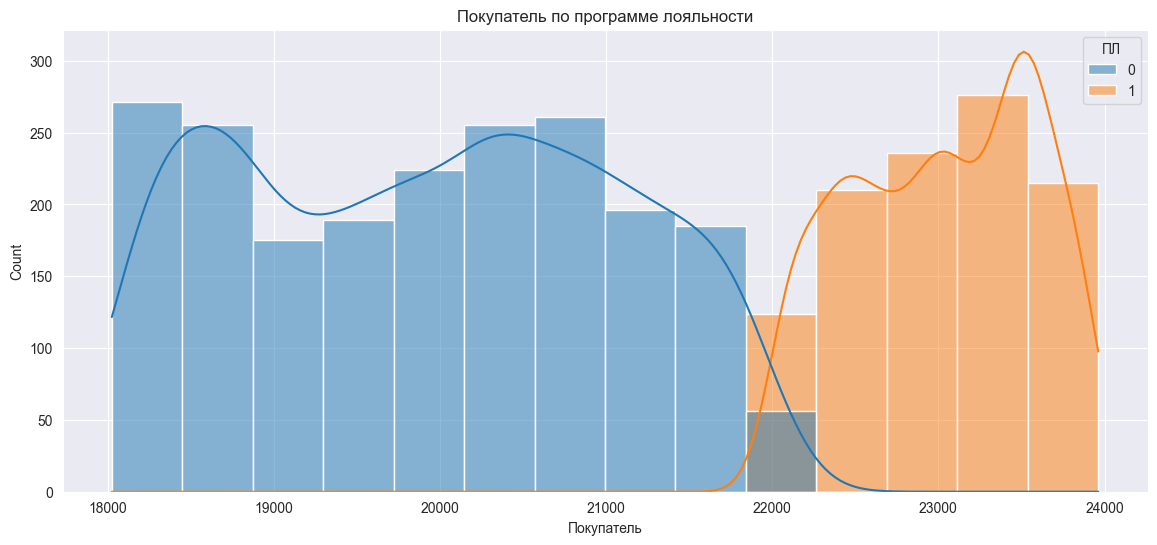

In [432]:
#строим график
sns.set_style("darkgrid")
plt.figure(figsize=(14,6))
sns.histplot(data=df_purchase_filter, x='Покупатель', hue="ПЛ", kde=True)
plt.title('Покупатель по программе лояльности')
plt.show()

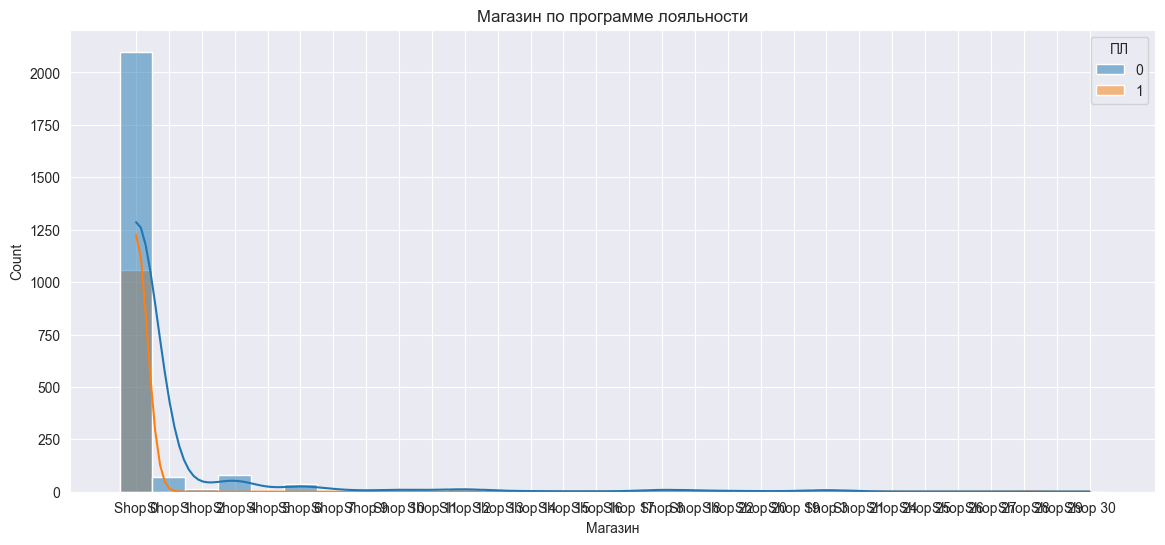

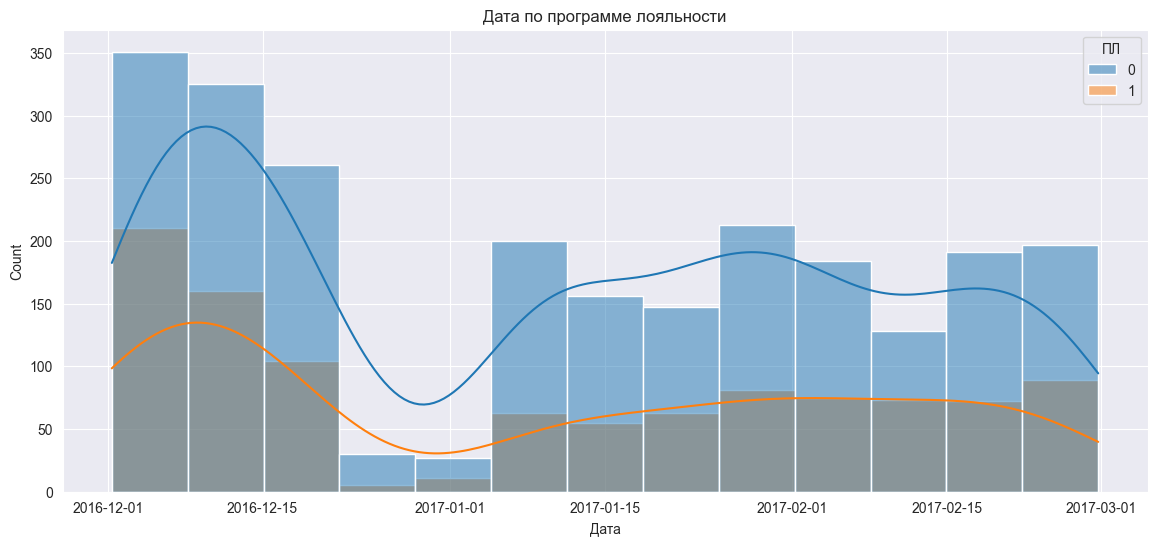

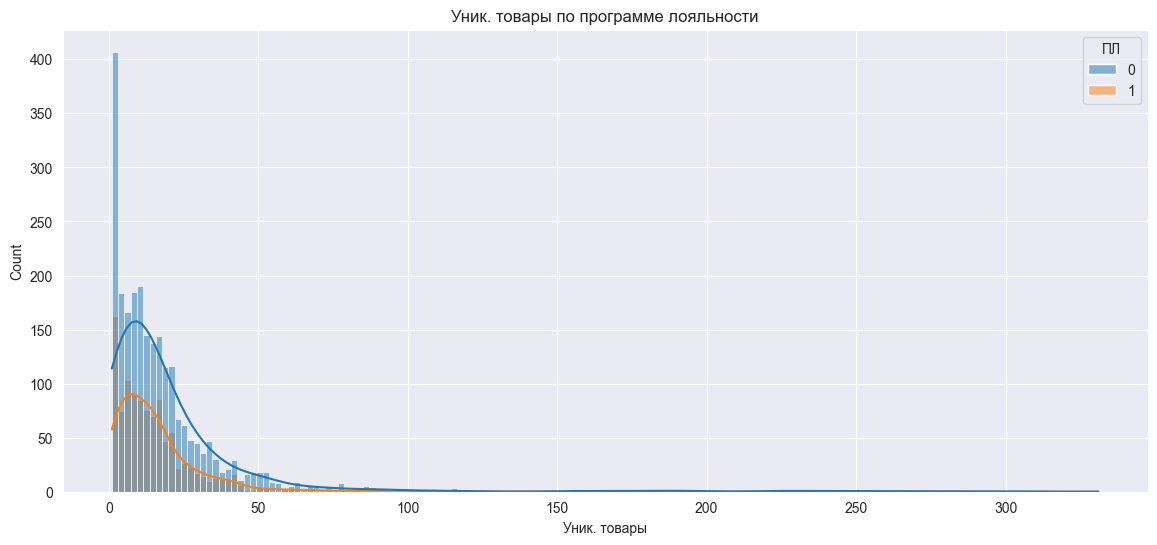

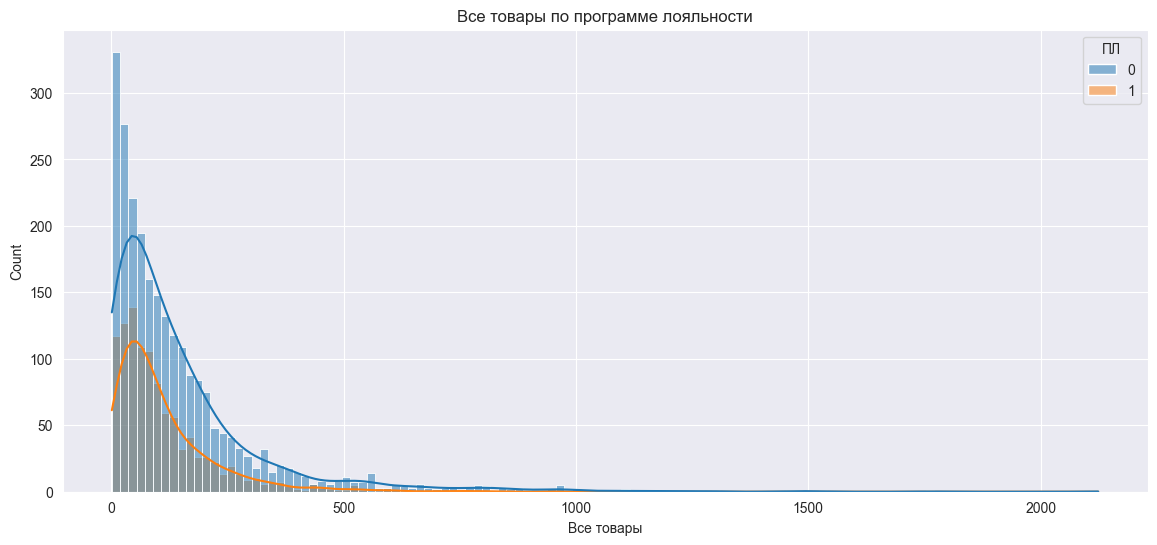

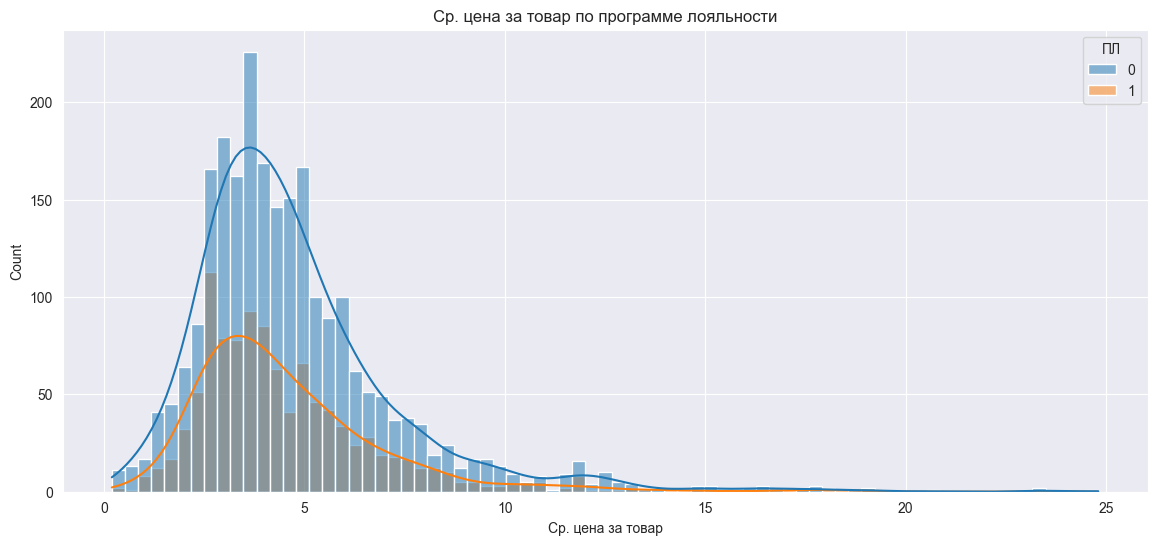

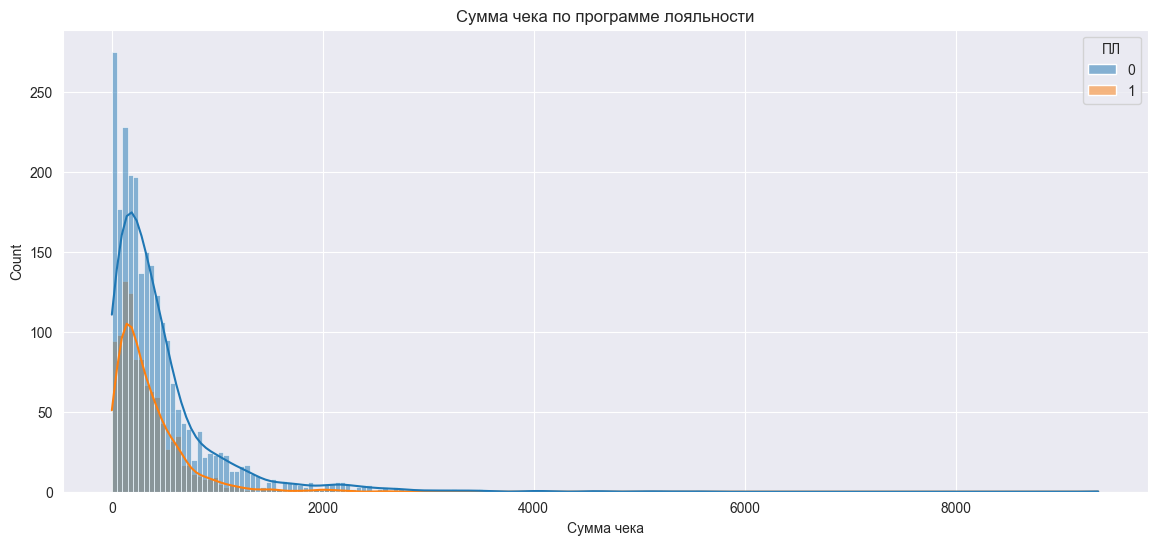

In [433]:
# цикл по признакам
for column in ['Магазин', 'Дата', 'Уник. товары', 'Все товары', 
               'Ср. цена за товар', 'Сумма чека']:
    sns.set_style("darkgrid")
    plt.figure(figsize=(14,6))
    sns.histplot(data=df_purchase, x=column, hue="ПЛ", kde=True)
    plt.title(f'{column} по программе лояльности')
    plt.show()

На графиках распределения покупки по программе лояльности (ПЛ) выделены оранжевым, а без - голубым.\
Все распределения по ПЛ и без схожи. График средней цены за товар у попкупок по ПЛ, немного смещен влево, значит покупаются более недорогие товары.\
По распределению по магазинам видно, что покупки по ПЛ делались только в Shop 0, в других ей пользуются в единиычных случаях.

На графике Покупатель сначала идут покупатели, которые не пользовались ПЛ, а с id 22000, которые пользовались.\
Посмотрим есть ли пользователи, которые находятся в двух категориях сразу, так как на графике есть пересечение.\
Для этого сгруппируем таблицу по customer_id, посчитаем число уникальных значений loyalty_program, выведем строки, где значение больше 1.

In [434]:
data_purchase.groupby('customer_id').agg({'loyalty_program': 'nunique'}).query('loyalty_program > 1')

,loyalty_program
customer_id,


Пересекающихся значений нет

Для получения точных значений, выведем числовые характеристики полученной таблицы для двух категорий методом describe 

In [435]:
# покупки по программе лояльности
print('Программа лояльности:')
display(df_purchase[df_purchase['ПЛ'] == 1].describe().round(1))
# обычные покупки
print('Обычные покупатели:')
display(df_purchase[df_purchase['ПЛ'] == 0].describe().round(1))

Программа лояльности:


,Покупатель,Уник. товары,Все товары,Ср. цена за товар,Сумма чека,ПЛ
count,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0
mean,23025.8,15.5,111.0,4.6,340.5,1.0
std,549.3,14.9,111.1,2.5,330.5,0.0
min,22005.0,1.0,1.0,0.4,2.4,1.0
25%,22554.0,6.0,39.0,3.0,128.9,1.0
50%,23056.0,12.0,78.0,4.0,250.6,1.0
75%,23520.0,20.0,143.0,5.5,447.8,1.0
max,23962.0,138.0,949.0,23.4,2901.5,1.0


Обычные покупатели:


,Покупатель,Уник. товары,Все товары,Ср. цена за товар,Сумма чека,ПЛ
count,2410.0,2410.0,2410.0,2410.0,2410.0,2410.0
mean,94072.7,20.6,146.1,4.7,457.9,0.0
std,182041.5,32.6,181.9,2.6,577.6,0.0
min,18026.0,1.0,1.0,0.2,0.4,0.0
25%,19087.0,6.0,36.0,3.1,132.5,0.0
50%,20285.0,13.0,92.0,4.2,299.5,0.0
75%,21384.0,23.0,182.8,5.6,545.1,0.0
max,545217.0,331.0,2124.0,24.8,9351.6,0.0


id пользователей по программе лояльности начинаются с номера 22005.\
Средние по числу уникальных товаров в чеке, числу всех товаров, средней цены на товар и среднего чека немного ниже у клиентов по ПЛ.

Средний чек по программе лояльности: 340.5\
Средний чек обычного покупателя: 457.9\
Разница в среднем чеке может быть из-за скидки по программе лояльности, также в количестве товаров,\
может покупатели по ПЛ чаще заходят, вследствие чего покупают меньше.

### Число чеков по покупателям

Чтобы посмотреть на количесво чеков по покупателям сгруппируем таблицу по customer_id и посчитаем уникальные чеки purchase_id,\
построим гистограмму с разделением по программе лояльности.

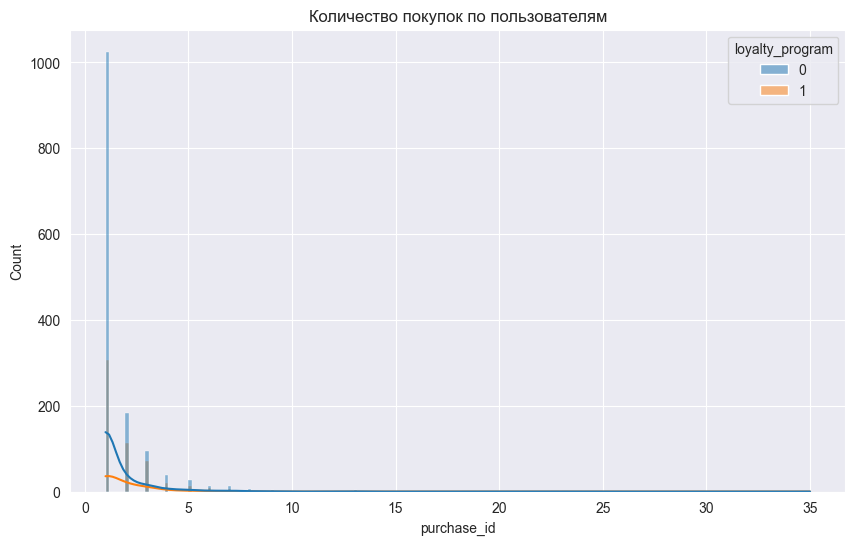

In [442]:
plt.figure(figsize=(10,6))
sns.histplot(data=data_purchase.groupby('customer_id').agg({'purchase_id': 'nunique', 'loyalty_program': 'max'}), 
             x='purchase_id', hue="loyalty_program", kde=True)
plt.title('Количество покупок по пользователям')
plt.show()

Распредиления покупок похожи.

### Вывод
Клиентов с программой лояльности 27.8%. Среднее число товаров - 7 и средняя цена товара - 4, у обеих выборок одинаковы. По средним значениям разницы в покупках по программе лояльности и без - нет.
Все распределения по чекам по программе лояльности и без схожи. По распрееделению по магазинам видно, что покупки по программе лояльности делались только в Shop 0, в других ей почти не пользуются.

Средние по числу уникальных товаров в чеке, числу всех товаров, средней цены за товар и среднего чека немного ниже у клиентов по программе лояльности.

Средний чек по программе лояльности: 340
Средний чек обычного покупателя: 457
Разница в среднем чеке может быть из-за скидки по программе лояльности, также в количестве приобритаемых товаров. Распределение количесва покупок у покупателей по программе лояльности и без очень схоже, то есть они одинково часто совершают покупки.

## Проверка статистических гипотез.

### Проверить гипотезу: средний чек участников программы лояльности выше, чем у остальных покупателей.
(Н0) Нулевая гипотеза: между средними чеками нет зачимой разницы\
(Н1) Альтернативная гипотеза: средний чек участников программы лояльности выше, чем у остальных покупателей

### Проверить гипотезу: среднее количество покупок участников программы лояльности выше, чем у остальных покупателей.
(Н0) Нулевая гипотеза: между средним количеством покупок нет зачимой разницы\
(Н1) Альтернативная гипотеза: среднее количество покупок участников программы лояльности выше, чем у остальных покупателей

### Проверить гипотезу: общая сумма денег, которую  клиент в среднем принёс компании со всех своих покупок участников программы лояльности выше, чем у остальных покупателей.
(Н0) Нулевая гипотеза: между общей суммой денег в среднем на клиента нет зачимой разницы\
(Н1) Альтернативная гипотеза: общая сумма денег, которую  клиент в среднем принёс компании со всех своих покупок участников программы лояльности выше, чем у остальных покупателей

In [436]:
#построим столбчатую диаграмму
#plt.figure(figsize=(14, 7))
#ax = sns.barplot(x='shop_id', y='purchase_id', data=retail_cut, estimator=count).set(title='Категориальное количество объектов общественного питания Москвы')
#plt.xticks(rotation=45);


In [437]:
#минимальная дата привлечения
#profiles['dt'].min()

#retail['customer_id'].unique().sum()

# преобразование данных о времени
#costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#Год выхода игр 'year_of_release' и оценки критиков 'critic_score' переведем из вещественного типа в целочисленный
#data['year_of_release'] = data['year_of_release'].astype('int')
#data['critic_score'] = data['critic_score'].astype('int')

#и приведем к вещественному типу 'object'
#data['user_score'] = data['user_score'].astype('float')

#удалим из самого датафрейма строки с явными дубликатами, оставив только первые вхождения: будем считать, что верные идентификаторы встречаются первыми
#data = data.drop_duplicates(subset=['name','platform'], keep='first')

In [438]:
retail.query('item_id == "21873"').head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,weekday
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,5
8572,540418,21873,1,2017-01-07 11:04:00,540418,Shop 0,0,5
13667,541516,21873,2,2017-01-18 17:34:00,541516,Shop 0,0,2
15301,541566,21873,35,2017-01-19 11:50:00,23401.0,Shop 0,1,3
18565,538843,21873,1,2016-12-14 13:18:00,21712.0,Shop 0,0,2


In [439]:
#
retail.groupby('shop_id').agg({'purchase_id':'count'}).sort_values(by='purchase_id', ascending=False).head()


,purchase_id
shop_id,
Shop 0,61681
Shop 4,1660
Shop 1,1425
Shop 6,901
Shop 8,498
